### Segmentez des clients d'un site e-commerce - Simulation

### Sommaire


* [1. 1. Importation des librairies et importation des fichiers](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Fonctions](#1_2)
    * [1.3 Importation des fichiers](#1_3)
* [2. DataFrame des dates de dernières commandes par client](#2)
* [3. Jointure des dates de dernières commandes sur df_clustering](#3)
* [4. Séparation du DataFrame en 2 parties pour simuler 'anciennes' et 'nouvelles' données](#4)
* [5. Plan de maintenance avec comparaison du modèle initiale et d'un modèle réentrainé sur les dernières données](#5)
    * [5.1 Choix du nombre optimal de clusters sur la simulation des 'anciennes' données](#5_1)
    * [5.2 Entraînement du modèle initial sur la simulation des 'anciennes' données](#5_2)
    * [5.3 Calcul de l'ARI pour connaître la stabilité des prédictions du modèle de semaine en semaine](#5_3)
    * [5.4 Visualisation de la stabilité du modèle en fonction du temps (simulé)](#5_4)

## 1. Importation des librairies et importation des fichiers <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# Data
import pandas as pd

# Scaler
from sklearn.preprocessing import StandardScaler

# KMeans
from sklearn.cluster import KMeans

# Pour les scores
from sklearn.metrics import silhouette_score

# ARI
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1.2 Fonctions <a class="anchor" id="1_2"></a>

In [2]:
def num_clusters_kmeans(df):
    """Choix du nombre optimal de clusters (méthode du coude et du score de silhouette) pour KMeans"""
    inertias = []
    silhouettes =[]
    davies = []
    K = range(2, 10)

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(df)
        inertias.append(kmeanModel.inertia_)
        silhouettes.append(silhouette_score(df, kmeanModel.labels_))
        davies.append(davies_bouldin_score(df, kmeanModel.labels_))

    # Rajouter les données dans un Dataframe
    df_resultats_KMeans = pd.DataFrame({
        'Type': 'KMeans',
        'n_clusters': K,
        'Silhouette': silhouettes,
        'Davies_Bouldin' : davies
    })

    # Trier dans l'ordre décroissant des score de silhouette
    df_resultats_KMeans = df_resultats_KMeans.sort_values(by='Silhouette', ascending=False)

    # Tracer la courbe de l'inertie en fonction du nombre de clusters
    plt.figure()
    plt.plot(K, inertias)
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude')

    # Graphique du score de silhouette
    plt.figure()
    plt.plot(K, silhouettes, marker='o')
    plt.xlabel('k')
    plt.ylabel('Score de silhouette')
    plt.title('Le score de silhouette montrant le k optimal')

    # Graphique du score de Davies Bouldin
    plt.figure()
    plt.plot(K, davies, marker='o')
    plt.xlabel('k')
    plt.ylabel('Indice de Davies-Bouldin')
    plt.title("L'indice de Davies-Bouldin montrant le k optimal")

    plt.tight_layout()
    plt.show()
    return df_resultats_KMeans

### 1.3 Importation des fichiers <a class="anchor" id="1_3"></a>

In [3]:
df_clustering = pd.read_csv('df_clustering.csv')
df_merge = pd.read_csv('df_merge.csv')

## 2. DataFrame des dates de dernières commandes par client <a class="anchor" id="2"></a>

In [4]:
# Mettre le colonne 'order_purchase_timestamp' au format date
df_merge['order_purchase_timestamp'] = pd.to_datetime(df_merge['order_purchase_timestamp'])

# Groupby pour les dernières dates de commandes
last_date_order = df_merge.groupby('customer_unique_id')['order_purchase_timestamp'].max()
df_last_date_order = last_date_order.reset_index(name='last_order_date')
df_last_date_order.head()

,customer_unique_id,last_order_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


## 3. Jointure des dates de dernières commandes sur df_clustering <a class="anchor" id="3"></a>

In [5]:
# Merger les dates
df_clustering_date = pd.merge(df_clustering, df_last_date_order, on='customer_unique_id', how='left')
df_clustering_date.set_index('customer_unique_id', inplace=True)
df_clustering_date.head()

,R_recence,F_frequence,M_montant,Mean_review_score,last_order_date
customer_unique_id,,,,,
7c396fd4830fd04220f754e42b4e5bff,331,2,82.82,4.25,2017-10-02 10:56:33
0f4389ffbcaa187a02a5ebeb0a2e616c,136,1,297.20,4.00,2018-04-14 23:13:00
0f09cdca721fc27f3db141488a6ba143,35,1,80.31,5.00,2018-07-24 23:00:46
0f687670823f779b76513fc03d33aab2,429,1,64.77,5.00,2017-06-25 22:18:02
0036a074f98b80c4f1fc33dbbcf9c552,474,1,42.62,5.00,2017-05-12 09:24:26


## 4. Séparation du DataFrame en 2 parties pour simuler 'anciennes' et 'nouvelles' données <a class="anchor" id="4"></a>

Il faut séparer le DataFrame en 2 : 
- d'un côté les données qui serviront de "passé" avec la première année du DataFrame ;
- d'un autre côté les données qui serviront de "futur" avec le reste du DataFrame.

In [6]:
# Trier le DataFrame par date d'achat
df_clustering_date = df_clustering_date.sort_values(by='last_order_date')

# Déterminer la date minimum du DataFrame
date_min = df_clustering_date['last_order_date'].min()

# Séparer le DataFrame en 2 :
# D'un côté un df_initial avec les clients qui ont commandé la première année
date_cut = date_min + pd.Timedelta(weeks=52)
df_initial_date = df_clustering_date[df_clustering_date['last_order_date'] <= date_cut]
df_initial = df_initial_date[['R_recence', 'F_frequence', 'M_montant', 'Mean_review_score']]

# D'un autre côté avec les clients qui ont commandé après la première année
df_simulation_date = df_clustering_date[df_clustering_date['last_order_date'] > date_cut + pd.Timedelta(days=1)]
df_simulation = df_simulation_date[['R_recence', 'F_frequence', 'M_montant', 'Mean_review_score']]

## 5. Plan de maintenance avec comparaison du modèle initiale et d'un modèle réentrainé sur les dernières données <a class="anchor" id="5"></a>

### 5.1 Choix du nombre optimal de clusters sur la simulation des 'anciennes' données <a class="anchor" id="5_1"></a>

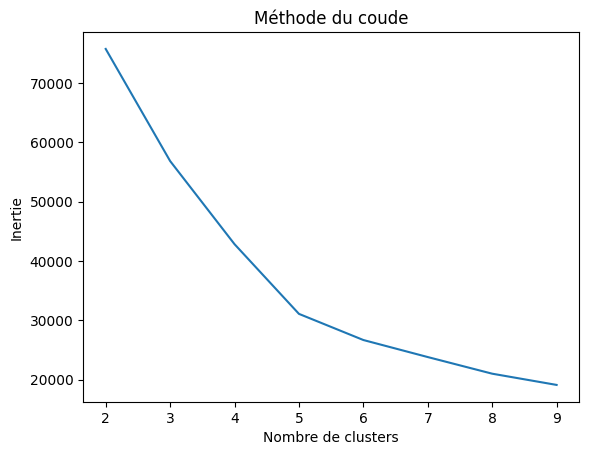

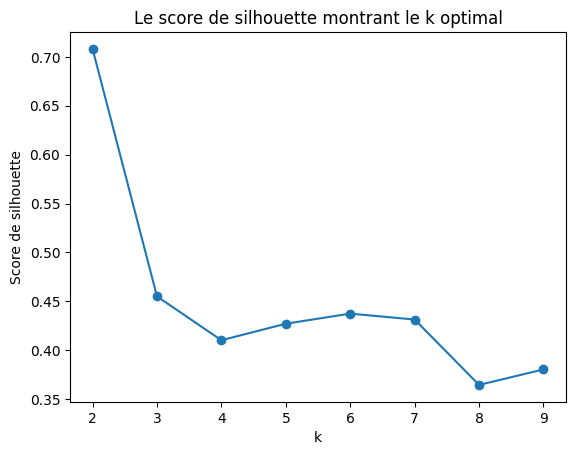

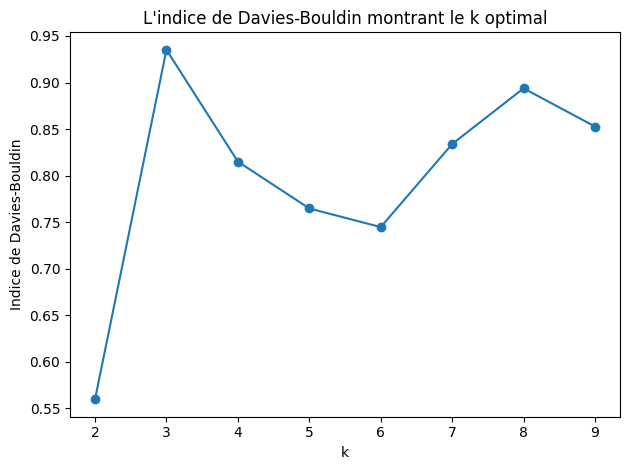

,Type,n_clusters,Silhouette,Davies_Bouldin
0,KMeans,2,0.708054,0.559422
1,KMeans,3,0.455021,0.935155
4,KMeans,6,0.437399,0.744542
5,KMeans,7,0.431352,0.833847
3,KMeans,5,0.427086,0.764547
2,KMeans,4,0.410177,0.814966
7,KMeans,9,0.380346,0.852670
6,KMeans,8,0.364499,0.893715


In [7]:
# Normaliser les données
std_scaler = StandardScaler()
scaler_init = std_scaler.fit(df_initial)
df_normalized = scaler_init.transform(df_initial)

# Choix du nombre optimal de clusters (méthode du coude et du score de silhouette)
df_resultats_KMeans = num_clusters_kmeans(df_normalized)
df_resultats_KMeans

En utilisant la méthode du coude, nous constatons que le nombre idéal de clusters est de 5. 
En se basant sur le score Silhouette et sur l'indice de Davies-Bouldin l'option de 6 clusters semble être la meilleure.

### 5.2 Entraînement du modèle initial sur la simulation des 'anciennes' données <a class="anchor" id="5_2"></a>

In [8]:
# Choix du nombre de clusters
k = 6

# Appliquer KMeans avec le nombre de clusters
kmeans_intial = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans_intial.fit(df_normalized)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [9]:
# Attribuer les labels du KMeans aux clients
df_KMeans = df_initial.copy()
df_KMeans['KMeans_label'] = kmeans_intial.labels_
df_KMeans.head()

,R_recence,F_frequence,M_montant,Mean_review_score,KMeans_label
customer_unique_id,,,,,
2f64e403852e6893ae37485d5fcacdaf,694,1,39.09,4.0,0
61db744d2f835035a5625b59350c6b63,694,1,53.73,3.0,0
8d3a54507421dbd2ce0a1d58046826e0,694,1,133.46,1.0,3
87776adb449c551e74c13fc34f036105,694,1,40.95,5.0,0
7390ed59fa1febbfda31a80b4318c8cb,694,1,154.57,5.0,0


In [10]:
# Afficher le nombre de clients par clusters
df_count_KMeans = pd.DataFrame(df_KMeans['KMeans_label'].value_counts())
df_count_KMeans

,count
KMeans_label,
1,11228
0,8266
3,3779
2,629
4,614
5,64


### 5.3 Calcul de l'ARI pour connaître la stabilité des prédictions du modèle de semaine en semaine <a class="anchor" id="5_3"></a>

Il faut maintenant voir comment le modèle se comporte sur les données futures sans réentraînement face au même modèle que nous réentraîneront toutes les semaines. 
Pour comparer les prédictions des deux modèles nous utiliseront l'indice de Rand (Adjusted Rand Index (ARI)).


In [11]:
# Date min du DataFrame df_simulation_date
date_min = df_simulation_date['last_order_date'].min()

# Date max du DataFrame df_simulation_date
date_max = df_simulation_date['last_order_date'].max()

jour = []
semaine = []
score_ari = []
D = pd.date_range(date_min, date_max, freq='W')
i = 1

for date in D:
    # Créer un nouveau DataFrame df_temp avec une semaine suplémentaire par rapport au df_initial
    df_date = df_simulation_date[df_simulation_date['last_order_date'] <= date]
    df_date = df_date[['R_recence', 'F_frequence', 'M_montant', 'Mean_review_score']]
    df_temp = pd.concat([df_initial, df_date], ignore_index=True)

    # Scaler les données avec l'ancien scaler pour l'ancien modèle
    df_temp_norm_init = scaler_init.transform(df_temp)

    # Scaler les données pour le nouveau modèle
    scaler = StandardScaler()
    df_temp_norm = scaler.fit_transform(df_temp)
    
    # Prédire les clusters avec l'ancien modèle
    prediction_init = kmeans_intial.predict(df_temp_norm_init)
    
    # Entrainer et prédire avec le nouveau modèle
    kmeans_new = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_new.fit(df_temp_norm)
    prediction_new = kmeans_new.labels_

    # Calcul du score ARI
    ari_temp = adjusted_rand_score(prediction_init, prediction_new)

    # Rajouter dans les listes
    jour.append(date)
    semaine.append(i)
    score_ari.append(ari_temp)

    # Incrémenter la variable i
    i = i+1

# Créer un DataFrame à partir des résultats
df_ari_results = pd.DataFrame({'Date': date, 'Semaine': semaine, 'ARI_Score': score_ari})
df_ari_results.head(10)

,Date,Semaine,ARI_Score
0,2018-08-26 17:00:40,1,0.965457
1,2018-08-26 17:00:40,2,0.905417
2,2018-08-26 17:00:40,3,0.856606
3,2018-08-26 17:00:40,4,0.834628
4,2018-08-26 17:00:40,5,0.812665
5,2018-08-26 17:00:40,6,0.771691
6,2018-08-26 17:00:40,7,0.678334
7,2018-08-26 17:00:40,8,0.689391
8,2018-08-26 17:00:40,9,0.647253
9,2018-08-26 17:00:40,10,0.614169


### 5.4 Visualisation de la stabilité du modèle en fonction du temps (simulé) <a class="anchor" id="5_4"></a>

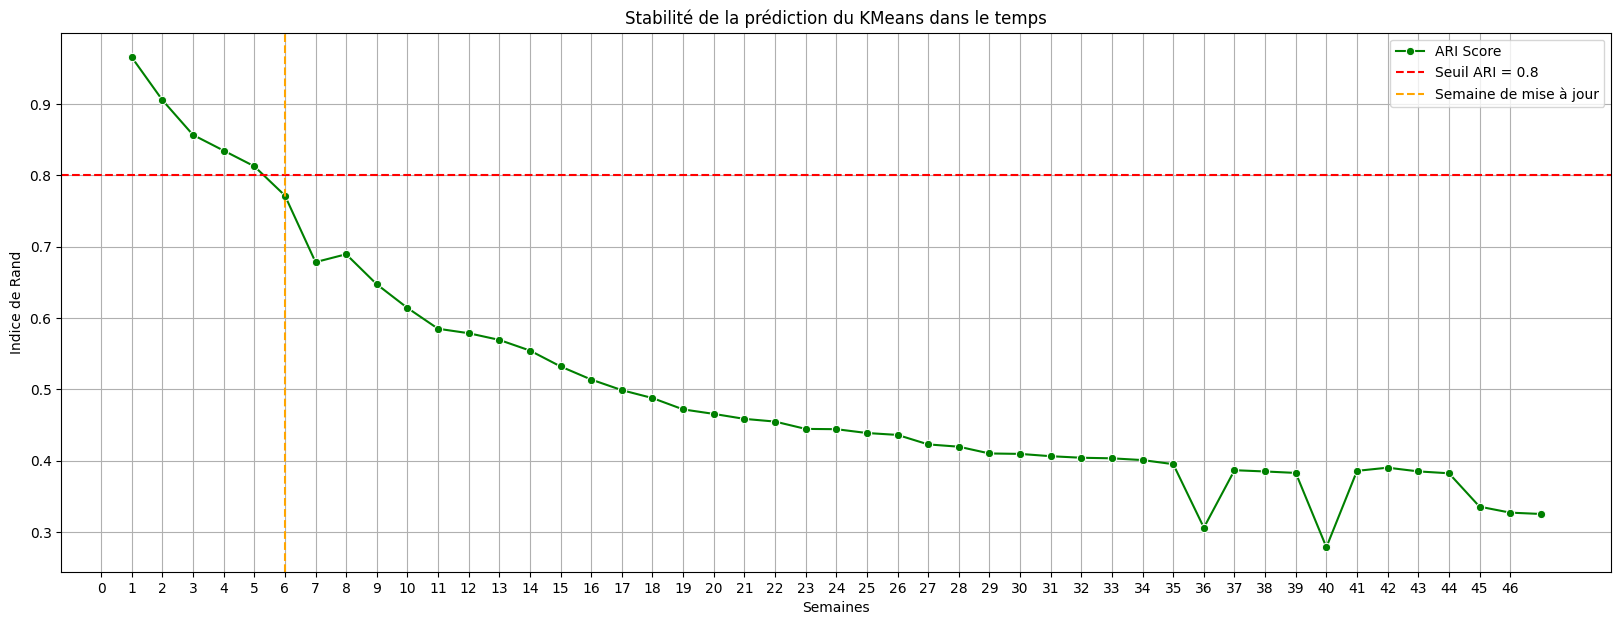

In [12]:
plt.figure(figsize=(20,7))
sns.lineplot(
    x='Semaine', 
    y='ARI_Score', 
    data=df_ari_results, 
    marker='o', 
    color='green', 
    label='ARI Score'
)
plt.axhline(y=0.8, color='r', linestyle='--', label='Seuil ARI = 0.8')
plt.axvline(x=6, color='orange', linestyle='--', label='Semaine de mise à jour')
plt.xlabel('Semaines')
plt.xticks(range(0, 47, 1))
plt.ylabel('Indice de Rand')
plt.title('Stabilité de la prédiction du KMeans dans le temps')
plt.legend()
plt.grid()
plt.show()

Si on prend le seuil de 0.8, la mise à jour du modèle devrait être effectuée à la semaine 6, soit 1 mois et demi après l’avoir entraîné sur les données.

